<a href="https://colab.research.google.com/github/jjyothika15/aicte-internship-june-2025/blob/main/garbage_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🗑️ Garbage Classification using EfficientNetV2B2
## Project Description
In this project, we aim to develop a sophisticated **garbage classification system** leveraging the **EfficientNetV2B2** architecture. Our primary dataset serves as a foundation for building models that can eventually automate waste segregation, a critical step in optimizing recycling and waste management, ultimately aiding in environmental conservation.

**Goal:** To develop an accurate and efficient garbage classification model using EfficientNetV2B2 and transfer learning for automated waste sorting.

## Challenges and Scope
**Key Challenge:** A notable challenge encountered is the inherent **class imbalance** within the dataset.


## Transfer Learning

Transfer Learning is a machine learning technique where a pre-trained model developed for a specific task is reused as the starting point for a model on a different but related task. This approach is beneficial when there is limited data for the new task, as the pre-trained model already has learned features that can be adapted.

### Benefits
- **Reduces training time**
- **Leverages learned features**
- **Improves performance** with less data

## How Does It Work?
1. Load a pretrained model (e.g., ResNet, EfficientNet).
2. Freeze the pretrained layers (optional).
3. Add new layers for your custom task.
4. Train on your new dataset (can also fine-tune).

---

## EfficientNetV2B2: Transfer Learning Backbone

EfficientNetV2B2 is a mid-sized model from the EfficientNetV2 family developed by Google.

### ⚙️ Key Features
- Fused MBConv blocks — enhance training stability and speed.
- Progressive learning — better generalization with fewer computations.
- Pretrained on ImageNet — ready for transfer learning.

### Why Use EfficientNetV2B2?

| Feature               | Description                              |
|----------------------|------------------------------------------|
| Balanced Performance | Good trade-off between speed and accuracy|
| Scalable             | Great for moderately sized datasets       |
| Efficient            | Trains faster, needs fewer resources     |


In [1]:

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2B2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import numpy as np


print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.18.0


In [2]:

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
dataset_path = '/content/drive/MyDrive/garbage_dataset'
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

train_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.


In [4]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_gen.classes),
    y=train_gen.classes
)
class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weight_dict)


Class weights: {0: np.float64(1.04437564499484), 1: np.float64(0.8412302576891105), 2: np.float64(1.0284552845528456), 3: np.float64(0.7086834733893558), 4: np.float64(0.8739205526770294), 5: np.float64(3.066666666666667)}


In [5]:
base_model = EfficientNetV2B2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
output = Dense(train_gen.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)


model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


35839040/35839040 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          0 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ normalization[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 112, 112,  │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, 112, 112,  │      2,304 │ block1a_project_… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, 112, 112,  │         64 │ block1b_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, 112, 112,  │          0 │ block1b_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, 112, 112,  │          0 │ block1b_project_… │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, 112, 112,  │          0 │ block1b_drop[0][… │
│                     │ 16)               │            │ block1a_project_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 56, 56,    │      9,216 │ block1b_add[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 56, 56,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 56, 56,    │          0 │ block2a_expand_b

 Total params: 8,950,500 (34.14 MB)

 Trainable params: 8,868,212 (33.83 MB)

 Non-trainable params: 82,288 (321.44 KB)

In [8]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

steps_per_epoch = train_gen.samples // train_gen.batch_size
val_steps = val_gen.samples // val_gen.batch_size

history = model.fit(
    train_gen,
    validation_data=val_gen,
    steps_per_epoch=steps_per_epoch,
    validation_steps=val_steps,
    epochs=10,
    class_weight=class_weight_dict,
    callbacks=[early_stop],
    verbose=1
)



Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 957s 15s/step - accuracy: 0.5873 - loss: 1.2213 - val_accuracy: 0.1729 - val_loss: 2.4893
Epoch 2/10
 1/63 ━━━━━━━━━━━━━━━━━━━━ 14s 236ms/step - accuracy: 0.5938 - loss: 0.7612

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 258ms/step - accuracy: 0.5938 - loss: 0.7612 - val_accuracy: 0.2062 - val_loss: 2.4460
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.7250 - loss: 0.7801 - val_accuracy: 0.1604 - val_loss: 2.5320
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 136ms/step - accuracy: 0.6562 - loss: 1.2643 - val_accuracy: 0.1604 - val_loss: 2.5465
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.7976 - loss: 0.5728 - val_accuracy: 0.1604 - val_loss: 3.2730
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.


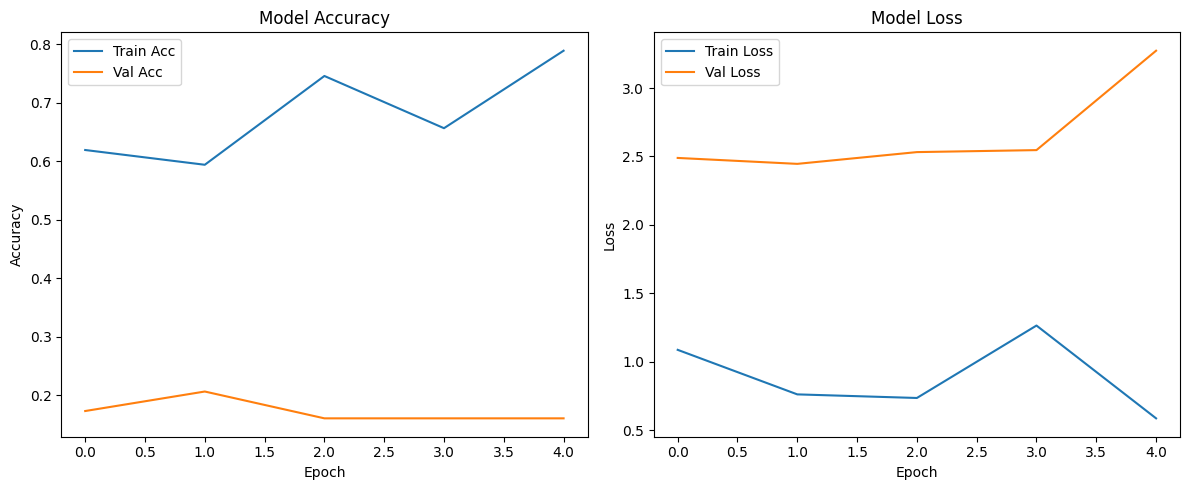

In [9]:

plt.figure(figsize=(12,5))


plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [10]:
model.save('/content/efficientnetv2b2_garbage_classifier_final.h5')
print("✅ Model saved.")


✅ Model saved.


Saving cardboard2.jpg to cardboard2.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Raw prediction probabilities: [[0.4619675  0.06657646 0.32852787 0.01755403 0.05819228 0.06718188]]


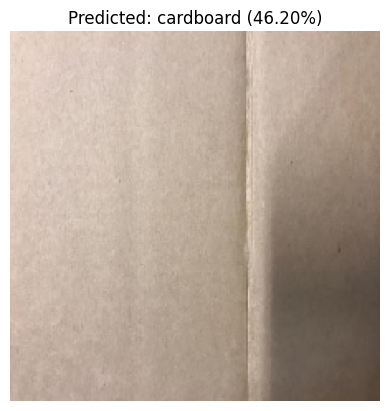

In [12]:
from tensorflow.keras.preprocessing import image
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt

uploaded = files.upload()
img_path = next(iter(uploaded))

img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

pred = model.predict(img_array)
print("Raw prediction probabilities:", pred)
pred_index = np.argmax(pred)
confidence = np.max(pred) * 100

class_names = [None] * len(train_gen.class_indices)
for name, idx in train_gen.class_indices.items():
    class_names[idx] = name

predicted_label = class_names[pred_index]


plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted: {predicted_label} ({confidence:.2f}%)")
plt.show()
